In [62]:
import os
import typing as t
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [63]:
# a) Your Python code should create three predictors (Distance, Obstacle_Type, Angle_Approach) and one output variable (Time_Collision)

print("****************************************************************")
print("Part 2 Data Exploration")
# Load the two datasets

# Looking at the csv contents I'm guessing the Group2_2 is the glass dataset since there's more vairablity
# in the values on first inspection (glass refracts more than concrete).
concrete_candidate_df = pd.read_csv(os.path.join("data", "Group2_1.csv"))
glass_candidate_df = pd.read_csv(os.path.join("data", "Group2_2.csv"))


# I can confirm this by using .describe() for the distance/ "Value" column.=

# summary_file1, summary_file2
print("Group2_1 dataset:\n")
print(concrete_candidate_df["Value"].describe(), "\n")
print("Group2_2 dataset:\n")
print(glass_candidate_df["Value"].describe(), "\n")
print("The Group2_2 dataset is more variable -> assuming it is the glass dataset.")

print("****************************************************************")
print("2 a) Create three predictors...")
# Assign Obstacle_Type based on assumed identifications
np.random.seed(1)
for df, obs_type in zip(
    [glass_candidate_df, concrete_candidate_df], ["Glass", "Concrete"]
):
    # black magic line
    df["Obstacle_Type"] = pd.Series(obs_type, np.arange(len(df))).astype("category")
    df["Angle_Approach"] = (10 if obs_type == "Concrete" else 0) + np.random.uniform(
        -5, 5, size=len(df)
    )
    df["Time_Collision"] = df["Value"] / 24
    df["Time"] = pd.to_datetime(df["Time"])
    df.rename(columns={"Value": "Distance"}, inplace=True)


concrete_candidate_df

****************************************************************
Part 2 Data Exploration
Group2_1 dataset:

count    169.000000
mean      72.079053
std       62.982411
min        3.540000
25%        3.540000
50%       66.140000
75%      119.680000
max      203.150000
Name: Value, dtype: float64 

Group2_2 dataset:

count    164.000000
mean      97.530183
std      107.704447
min        5.510000
25%        9.155000
50%       71.060000
75%      147.832500
max      470.470000
Name: Value, dtype: float64 

The Group2_2 dataset is more variable -> assuming it is the glass dataset.
****************************************************************
2 a) Create three predictors...


/tmp/ipykernel_19458/963353629.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"])
/tmp/ipykernel_19458/963353629.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"])


,Time,Distance,Obstacle_Type,Angle_Approach,Time_Collision
0,2024-11-16 16:40:57,189.37,Concrete,6.567914,7.890417
1,2024-11-16 16:40:58,186.22,Concrete,5.185762,7.759167
2,2024-11-16 16:40:58,88.58,Concrete,5.700221,3.690833
3,2024-11-16 16:40:59,88.58,Concrete,9.863451,3.690833
4,2024-11-16 16:40:59,88.58,Concrete,11.063295,3.690833
...,...,...,...,...,...
164,2024-11-16 16:41:17,3.54,Concrete,10.440101,0.147500
165,2024-11-16 16:41:17,3.54,Concrete,11.541373,0.147500
166,2024-11-16 16:41:17,3.54,Concrete,6.445455,0.147500
167,2024-11-16 16:41:17,3.54,Concrete,12.515278,0.147500


In [ ]:
# b) Your team can trim a few seconds of last rows of data where the same distance “Value” column in the datasets is exactly repeated.

print("****************************************************************")
print("2 b) Trim a few seconds of last rows of data...")


class _Row(t.NamedTuple):
    index: int
    series: pd.Series


def strip_similar_rows(
    df: pd.DataFrame,
    columns: str | list[str],
    side: t.Literal["start", "end", "both"] = "end",
    thresh=0.1,
) -> list[_Row]:
    """
    THIS MUTATES THE DF

    strips the rows that are similar to the last row (acc to `tresh`), but leaves the last
    expects the dataframe to have an integer index

    args:
        - df (DataFrame): the dataframe to operate on
        - columns (str | list[str]): column(s) of the values to compare
        - side ("start", "end", "both"): where to strip rows, default "end"
        - tresh (float): +/- val to consider \n
    returns:
        - None

    """
    last = df[columns].iloc[-1]
    if side == "both":
        side = "end"
        strip_similar_rows(df, columns, "start", thresh)
    rows_since_dupe = 0
    to_drop: list[_Row] = []
    for i, row in (df[::-1] if side == "end" else df).iterrows():
        if rows_since_dupe > 1:
            break
        if not (last - thresh <= row[columns] <= last + thresh):
            rows_since_dupe += 1
            continue
        to_drop.append(_Row(i, row))
    df.drop(index=[i.index for i in to_drop], inplace=True)
    df.loc[len(df)] = to_drop[-1].series
    return to_drop


strip_similar_rows(glass_candidate_df, "Distance", "end", 0.2)
strip_similar_rows(concrete_candidate_df, "Distance", "end", 0.4)

****************************************************************
2 b) Trim a few seconds of last rows of data...


In [65]:
print("****************************************************************")
print("2 c) Deal with seconds that do not have exactly 10 records...")

numeric_cols: list[str] | None = None
for df in (concrete_candidate_df, glass_candidate_df):
    if not numeric_cols:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    for _time, _count in df.groupby("Time").count()["Distance"].items():
        row_to_opp = df.loc[(df["Time"] == _time)]  # row to operate on
        if row_to_opp.empty:
            continue
        while _count > 10:
            df.drop(index=row_to_opp.iloc[0].index, inplace=True)
            _count -= 1
        if _count == 10:
            continue
        new_row: pd.Series = row_to_opp[numeric_cols].mean()
        for col in (c for c in df.columns if c not in numeric_cols):
            new_row[col] = row_to_opp[col].iloc[0]  # fill in non-numeric-cols
        for _ in range(10 - _count):
            df.loc[len(df)] = new_row
    df.sort_values(["Time", "Distance"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)

****************************************************************
2 c) Deal with seconds that do not have exactly 10 records...


In [66]:
print("****************************************************************")
print("2 d) Report and handle missing and outlier values")
# print(data_combined.isnull().sum())
for df in (concrete_candidate_df, glass_candidate_df):
    _nulldf = df.isnull()

    print("missing values\n", _nulldf.sum())
    if any((_nulldf).any().to_dict().values()):
        print(
            f"null vals @ {_nulldf.loc[_nulldf[_nulldf.columns[0]]==True].index} prolly cause last oper, just gonna drop"
        )
        df.dropna(inplace=True)


def drop_outliers(df: pd.DataFrame, column: str, multip: float = 1.5):
    """use iqr to handle outliers

    mutates original df and returns a shallow ref
    """
    _q1 = df[column].quantile(0.25)
    _q3 = df[column].quantile(0.75)
    iqr = _q3 - _q1
    lower_bound = _q1 - multip * iqr
    upper_bound = _q3 + multip * iqr

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df


for df in (concrete_candidate_df, glass_candidate_df):
    for col in numeric_cols or []:
        drop_outliers(df, col)

print("\nSummary Statistics After Handling Outliers:")

data_combined = pd.concat([concrete_candidate_df, glass_candidate_df])
data_combined.to_csv(os.path.join("data", "out.csv"), index=False)
data_combined[numeric_cols].describe()

****************************************************************
2 d) Report and handle missing and outlier values
missing values
 Time              0
Distance          0
Obstacle_Type     0
Angle_Approach    0
Time_Collision    0
dtype: int64
missing values
 Time              0
Distance          0
Obstacle_Type     0
Angle_Approach    0
Time_Collision    0
dtype: int64

Summary Statistics After Handling Outliers:


,Distance,Angle_Approach,Time_Collision
count,370.000000,370.000000,370.000000
mean,110.402490,4.455749,4.600104
std,87.892614,5.864662,3.662192
min,5.120000,-4.998856,0.213333
25%,39.175000,-0.829780,1.632292
50%,99.605000,4.085653,4.150208
75%,163.190000,10.028680,6.799583
max,405.847500,14.886162,16.910312


****************************************************************
2 e) Make Two Plots [Box Plot and Line Plot]


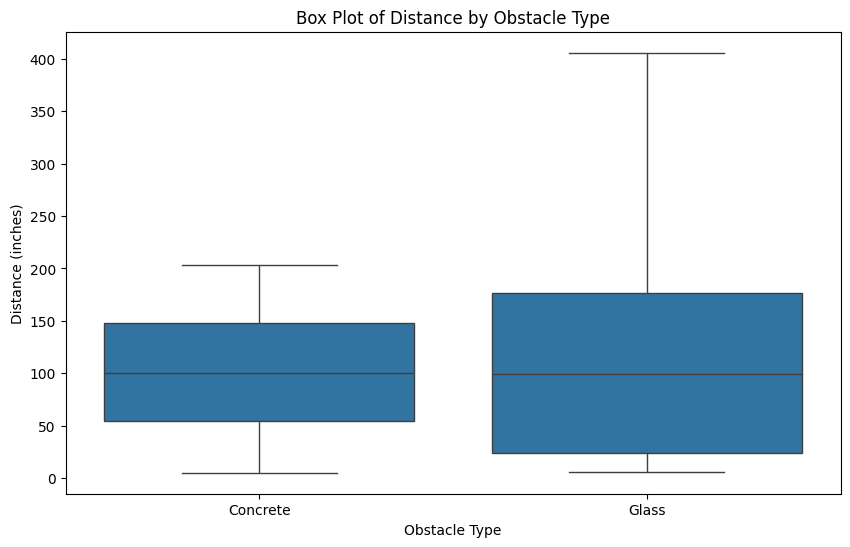

/tmp/ipykernel_19458/3628160930.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_combined["Second"] = data_combined["Time"].dt.floor("S")


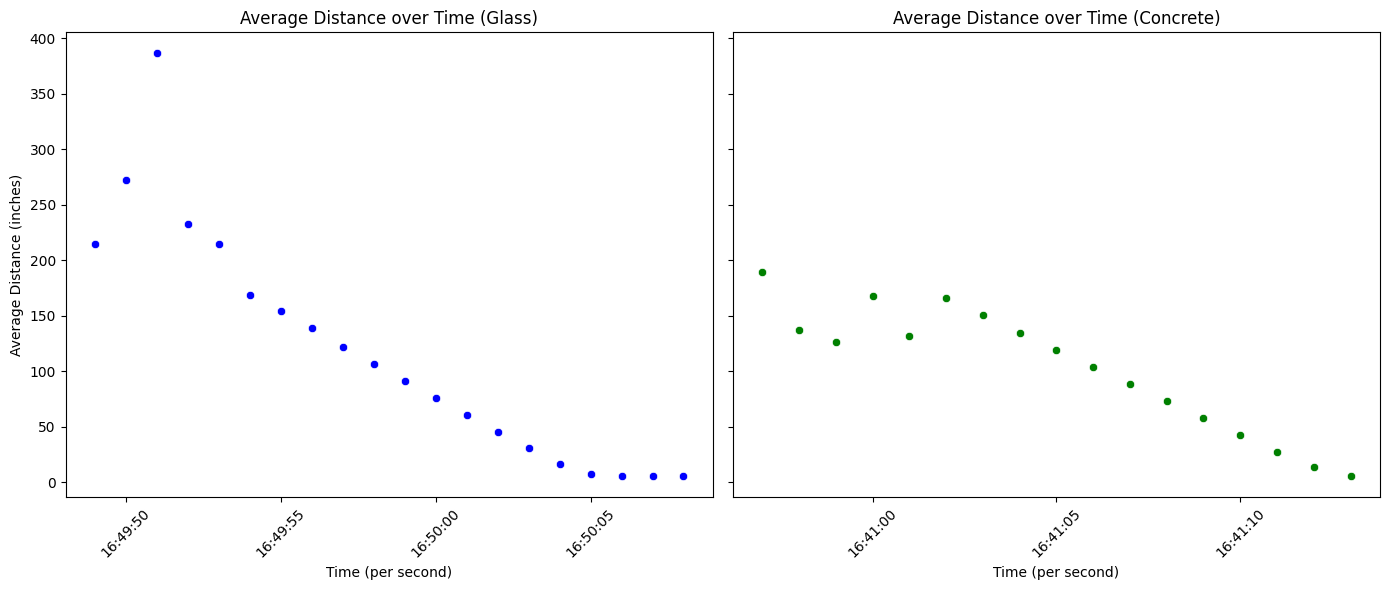

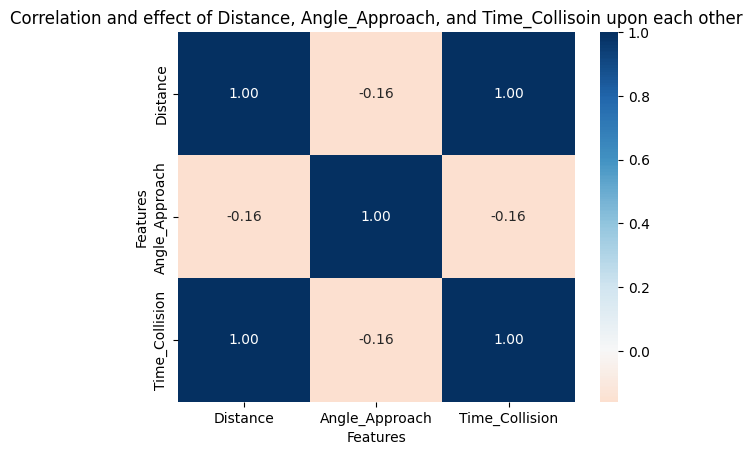

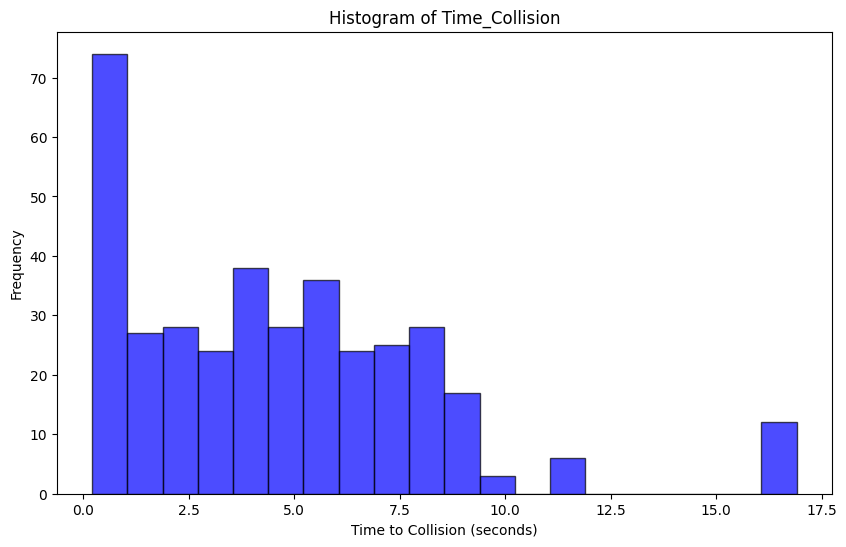

In [67]:
print("****************************************************************")
print("2 e) Make Two Plots [Box Plot and Line Plot]")

# Box Plot: Distance by Obstacle Type
plt.figure(figsize=(10, 6))
sns.boxplot(x="Obstacle_Type", y="Distance", data=data_combined)
plt.title("Box Plot of Distance by Obstacle Type")
plt.xlabel("Obstacle Type")
plt.ylabel("Distance (inches)")
plt.show()

# Scatter Plot: Average Distance over Time with Separate Axes for Each Obstacle Type
# Aggregate data to calculate average distance per second for each obstacle type
data_combined["Second"] = data_combined["Time"].dt.floor("S")
avg_distance_per_second = (
    data_combined.groupby(["Second", "Obstacle_Type"])["Distance"].mean().reset_index()
)

# Create separate scatter plots for glass and concrete
axes: list[plt.Axes]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scatter plot for Glass
sns.scatterplot(
    ax=axes[0],
    x="Second",
    y="Distance",
    data=avg_distance_per_second[avg_distance_per_second["Obstacle_Type"] == "Glass"],
    color="blue",
)
axes[0].set_title("Average Distance over Time (Glass)")
axes[0].set_xlabel("Time (per second)")
axes[0].set_ylabel("Average Distance (inches)")
axes[0].tick_params(axis="x", rotation=45)

# Scatter plot for Concrete
sns.scatterplot(
    ax=axes[1],
    x="Second",
    y="Distance",
    data=avg_distance_per_second[
        avg_distance_per_second["Obstacle_Type"] == "Concrete"
    ],
    color="green",
)
axes[1].set_title("Average Distance over Time (Concrete)")
axes[1].set_xlabel("Time (per second)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


# Heat Map
# Select only numeric columns for the heatmap
numeric_data = data_combined[["Distance", "Angle_Approach", "Time_Collision"]]
ax_heatmap = sns.heatmap(
    numeric_data.corr(),  # Use correlation matrix for better visualization
    xticklabels=numeric_data.columns.to_list(),
    yticklabels=numeric_data.columns.to_list(),
    cmap="RdBu",
    annot=True,
    fmt=".2f",
    center=0,
)
ax_heatmap.set_title(
    "Correlation and effect of Distance, Angle_Approach, and Time_Collisoin upon each other"
)
ax_heatmap.set_xlabel("Features")
ax_heatmap.set_ylabel("Features")
plt.show()

# Adding a Histogram of Time_Collision
plt.figure(figsize=(10, 6))
plt.hist(
    data_combined["Time_Collision"],
    bins=20,
    alpha=0.7,
    color="blue",
    edgecolor="black",
)
plt.title("Histogram of Time_Collision")
plt.xlabel("Time to Collision (seconds)")
plt.ylabel("Frequency")
plt.show()

In [68]:
print("****************************************************************")
print("2 f) Combine the two datasets for both scenarios")
print(
    "The datasteps were combined in 2 d). But we can still confirm the dataframe row count using .shape():"
)
print(data_combined.shape)

****************************************************************
2 f) Combine the two datasets for both scenarios
The datasteps were combined in 2 d). But we can still confirm the dataframe row count using .shape():
(370, 6)


In [69]:
print("****************************************************************")
print("2 g) Shuffle data to avoid data overfitting when using k-NN and Naive Bayes")


final_data_shuffled = pd.get_dummies(
    data_combined.sample(frac=1, random_state=42).reset_index(drop=True),
    columns=["Obstacle_Type"],
    dtype=int,
    drop_first=True,
)

# final_data_shuffled.to_csv(os.path.join("data", "out.csv"), index=False)
final_data_shuffled

****************************************************************
2 g) Shuffle data to avoid data overfitting when using k-NN and Naive Bayes


,Time,Distance,Angle_Approach,Time_Collision,Second,Obstacle_Type_Glass
0,2024-11-16 16:50:04,12.99,2.115248,0.541250,2024-11-16 16:50:04,1
1,2024-11-16 16:41:00,189.37,7.649196,7.890417,2024-11-16 16:41:00,0
2,2024-11-16 16:40:58,137.40,5.442992,5.725000,2024-11-16 16:40:58,0
3,2024-11-16 16:50:03,30.71,-4.841788,1.279583,2024-11-16 16:50:03,1
4,2024-11-16 16:41:02,163.78,14.319721,6.824167,2024-11-16 16:41:02,0
...,...,...,...,...,...,...
365,2024-11-16 16:41:04,139.76,14.261814,5.823333,2024-11-16 16:41:04,0
366,2024-11-16 16:41:07,87.01,5.155333,3.625417,2024-11-16 16:41:07,0
367,2024-11-16 16:49:59,98.43,1.637946,4.101250,2024-11-16 16:49:59,1
368,2024-11-16 16:50:06,5.51,-4.813527,0.229583,2024-11-16 16:50:06,1


In [70]:
print("****************************************************************")
print("Part 3 Model Training")

# Define features and target variable


features = final_data_shuffled[["Distance", "Angle_Approach", "Obstacle_Type_Glass"]]
target = final_data_shuffled["Time_Collision"]

# Split data into 60% training and 40% validation
X_train, X_val, y_train, y_val = train_test_split(
    features, target, test_size=0.4, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

****************************************************************
Part 3 Model Training


In [71]:
print("****************************************************************")
print("3 a) k-NN model")
# Initialize the k-NN model (you can start with k=5 or any other reasonable choice)
knn = KNeighborsRegressor(n_neighbors=5)

# Train the k-NN model
knn.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_pred = knn.predict(X_val_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("k-NN Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 Score): {r2}")
print(
    "Use a 5-fold cross-validation to confirm not Overfitting. If the scores vary wildly, this would indicate Overfitting."
)
# Perform 5-fold cross-validation
cv_scores = cross_val_score(knn, features, target, cv=5, scoring="r2")
print("Cross-Validation R-squared Scores:", cv_scores)
print("Average Cross-Validation R-squared:", cv_scores.mean())

****************************************************************
3 a) k-NN model
k-NN Model Performance:
Mean Squared Error (MSE): 0.042202167564855834
R-squared (R2 Score): 0.9961087529433968
Use a 5-fold cross-validation to confirm not Overfitting. If the scores vary wildly, this would indicate Overfitting.
Cross-Validation R-squared Scores: [0.99985109 0.99944014 0.99923836 0.99936482 0.99950348]
Average Cross-Validation R-squared: 0.9994795764172097


In [72]:
print("****************************************************************")
print("3 b) Naïve Bayes model")

final_data_shuffled["Time_Collision_Label"] = final_data_shuffled[
    "Time_Collision"
].apply(lambda x: "Close" if x < 2 else "Mid" if x < 6 else "Far")


# Step 2: Discretize Distance and Angle_Approach
# Using KBinsDiscretizer to create bins
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")
discrete_features = discretizer.fit_transform(
    final_data_shuffled[["Distance", "Angle_Approach"]]
)
final_data_shuffled[["Distance_binned", "Angle_Approach_binned"]] = discrete_features

# Step 3: Define features and target variable
features = final_data_shuffled[
    ["Distance_binned", "Angle_Approach_binned", "Obstacle_Type_Glass"]
]

target = final_data_shuffled["Time_Collision_Label"]

# Step 4: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    features, target, test_size=0.4, random_state=42
)

# Step 5: Train the Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Step 6: Validate the model
y_pred = nb.predict(X_val)

# Step 7: Report results
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("Multinomial Naive Bayes Model Performance:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

****************************************************************
3 b) Naïve Bayes model
Multinomial Naive Bayes Model Performance:
Accuracy: 0.6824324324324325
Classification Report:
              precision    recall  f1-score   support

       Close       0.72      1.00      0.84        42
         Far       0.60      0.62      0.61        39
         Mid       0.70      0.52      0.60        67

    accuracy                           0.68       148
   macro avg       0.67      0.71      0.68       148
weighted avg       0.68      0.68      0.67       148



In [73]:
print("****************************************************************")
print("Part 4 New Record Regression/Classification")

# Select one or a few random data points from the dataset
# Adjust n to select more samples if needed
random_samples = final_data_shuffled.sample(n=10, random_state=2)

# k-NN model prediction on continuous features
knn_prediction = knn.predict(
    scaler.transform(
        random_samples[["Distance", "Angle_Approach", "Obstacle_Type_Glass"]]
    )
)

# Naive Bayes model prediction on discretized features
nb_prediction = nb.predict(
    random_samples[["Distance_binned", "Angle_Approach_binned", "Obstacle_Type_Glass"]]
)

# Display the results
for i in range(len(random_samples)):
    print(f"Data Point {i+1}:")
    print(f"  True Time_Collision: {random_samples["Time_Collision"].iloc[i]}")
    print(f"  True Category (NB): {random_samples["Time_Collision_Label"].iloc[i]}")
    print(f"  k-NN Predicted Time_Collision: {knn_prediction[i]}")
    print(f"  Naive Bayes Predicted Category: {nb_prediction[i]}")
    print("\n")

****************************************************************
Part 4 New Record Regression/Classification
Data Point 1:
  True Time_Collision: 0.24625
  True Category (NB): Close
  k-NN Predicted Time_Collision: 0.26258333333333334
  Naive Bayes Predicted Category: Close


Data Point 2:
  True Time_Collision: 7.086666666666667
  True Category (NB): Far
  k-NN Predicted Time_Collision: 7.171916666666666
  Naive Bayes Predicted Category: Far


Data Point 3:
  True Time_Collision: 2.0995833333333334
  True Category (NB): Mid
  k-NN Predicted Time_Collision: 2.0577777777777775
  Naive Bayes Predicted Category: Close


Data Point 4:
  True Time_Collision: 6.266249999999999
  True Category (NB): Far
  k-NN Predicted Time_Collision: 6.801166666666665
  Naive Bayes Predicted Category: Mid


Data Point 5:
  True Time_Collision: 5.0730208333333335
  True Category (NB): Mid
  k-NN Predicted Time_Collision: 5.458562500000001
  Naive Bayes Predicted Category: Far


Data Point 6:
  True Time_Coll